Working dir -> /Users/tree/Projects/food-spoilage-poc
probs shape: (41,) labels shape: (41,)
label counts: [ 0 41]


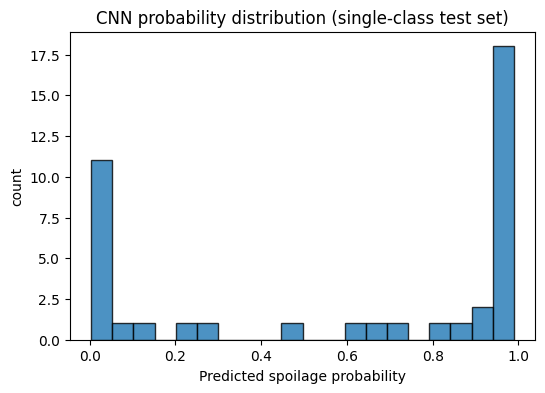

ROC / PR not defined because test set has a single class.
gbm {'cv_f1_mean': 1.0, 'test_f1': 1.0, 'best_threshold': 0.005, 'cost_fn': 10.0, 'cost_fp': 1.0, 'cost_total': 0.0, 'precision_at_tau': 1.0, 'recall_at_tau': 1.0, 'f1_at_tau': 1.0, 'fp_at_tau': 0, 'fn_at_tau': 0}
lstm {'cv_f1_mean': 0.9972932856020257, 'test_f1': 1.0, 'best_threshold': 0.275, 'cost_fn': 10.0, 'cost_fp': 1.0, 'cost_total': 0.0, 'precision_at_tau': 1.0, 'recall_at_tau': 1.0, 'f1_at_tau': 1.0, 'fp_at_tau': 0, 'fn_at_tau': 0}
fusion {'fusion_f1': 1.0}


In [5]:
# ------------------------------------------------------------
#  Notebook-friendly snippet: CNN metrics + sensor model stats
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pathlib, os, sys, json
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ---- ensure we run from repo root -----------------------------------------
repo_root = (
    pathlib.Path.cwd().parent
    if pathlib.Path.cwd().name == "notebooks"
    else pathlib.Path.cwd()
)
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print("Working dir ->", pathlib.Path.cwd())

# ---- CNN artefacts --------------------------------------------------------
cnn_root = pathlib.Path("models/artifacts/dafif/cnn")
assert cnn_root.exists(), "Run `make run_cnn DATASET=dafif` first!"

img_probs  = np.load(cnn_root / "img_probs.npy")
img_labels = np.load(cnn_root / "img_labels.npy")

print("probs shape:", img_probs.shape, "labels shape:", img_labels.shape)
print("label counts:", np.bincount(img_labels.astype(int)))

# ---- Plot depending on label balance -------------------------------------
if len(np.unique(img_labels)) == 2:
    # ROC
    fpr, tpr, _ = roc_curve(img_labels, img_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.title("CNN ROC curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(img_labels, img_probs)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, lw=2)
    plt.title("CNN PR curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.ylim(0,1.05); plt.xlim(0,1); plt.show()
else:
    # Only one class present → show probability distribution
    plt.figure(figsize=(6,4))
    plt.hist(img_probs, bins=20, alpha=0.8, edgecolor="k")
    plt.title("CNN probability distribution (single-class test set)")
    plt.xlabel("Predicted spoilage probability"); plt.ylabel("count")
    plt.show()
    print("ROC / PR not defined because test set has a single class.")

# ---- Print sensor & fusion metrics ---------------------------------------
art_root = pathlib.Path("models/artifacts/dafif")
for m in ["gbm", "lstm", "fusion"]:
    with open(art_root / m / "metrics.json") as f:
        mets = json.load(f)
    print(m, mets)